# Li et al., 2015b - A DataJoint Example

This notebook replicates Figure 4 in Li et al., (2015). **"A motor cortex circuit for motor planning and movement."** 

Publication link: https://doi.org/10.1038/nature14178  
Original data link: https://dx.doi.org/10.6080/K0MS3QNT  

This study revealed the flow of information within motor cortex circuits involved in converting preparatory activity into movements. One important part of the motor cortex is known as anterior lateral motor cortex (ALM), which has been shown to involve in planing directed licking. Projection neurons in ALM include two major classes: intratelencephalic (IT) neurons that project to other cortical areas and pyramidal tract (PT) neurons that project out of the cortex, including to motor-related areas in the brainstem. Results in Figure 4, in particular, characterized the selectivity and preference of PT and IT neurons in ALM L5 on the population level.

A ***DataJoint*** data pipeline has been constructed for this study, with the presented data ingested into this pipeline. This notebook demonstrates the queries, processing, and reproduction of several figures from the paper. From the pipeline, export capability to ***NWB 2.0*** format is also available.

In this notebook, we will introduce the relevant part of the data pipeline for the imaging experiments and how to replicate the figures from the pipeline.

In [1]:
%matplotlib notebook

In [2]:
import datajoint as dj
from pipeline import lab, experiment, imaging
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

Connecting shan@host.docker.internal:3306


# Architecture of the data pipeline

Here, we introduced the architecture of the data pipeline created and maintained with DataJoint. This pipeline is mainly composed of three schemas:  

1. `lab`: a collection of tables for meta information, including subjects and their genetic information, actions on the subjects and device information.  
2. `experiment`: a collection of tables for behavioral information.  
3. `imaging`: a collection of tables for two-photon image recording.


## Diagram of schema `lab`

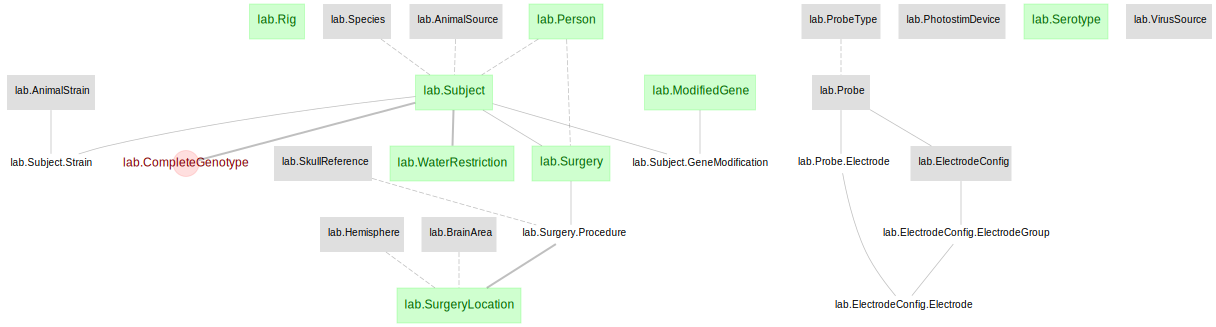

In [3]:
dj.Diagram(lab)

One of the most important tables in this schema is `lab.Subject`, with the following table definition. The primary key that uniquely identifies a subject is the `subject_id`.

In [4]:
lab.Subject.describe();

subject_id           : int                          # institution 6 digit animal ID
---
subject_nickname     : varchar(32)                  # name used in the filename
-> [nullable] lab.Person
cage_number=null     : int                          # institution 6 digit animal ID
date_of_birth=null   : date                         # format: yyyy-mm-dd
sex                  : enum('M','F','Unknown')      
-> lab.Species
-> [nullable] lab.AnimalSource



Table contents of lab.Subject:

In [5]:
lab.Subject()

subject_id institution 6 digit animal ID,subject_nickname name used in the filename,username,cage_number institution 6 digit animal ID,date_of_birth format: yyyy-mm-dd,sex,species,animal_source
216219,an019,None,None,2013-05-16,M,Mus musculus,Jackson lab
217951,an023,None,None,2013-04-22,M,Mus musculus,Jackson lab
221541,an022,None,None,2013-05-20,M,Mus musculus,Jackson lab
226244,an026,None,None,2013-07-08,M,Mus musculus,Jackson lab


Four animals have been involved in the imaging experiments in this study.

## Diagram of schema `experiment`

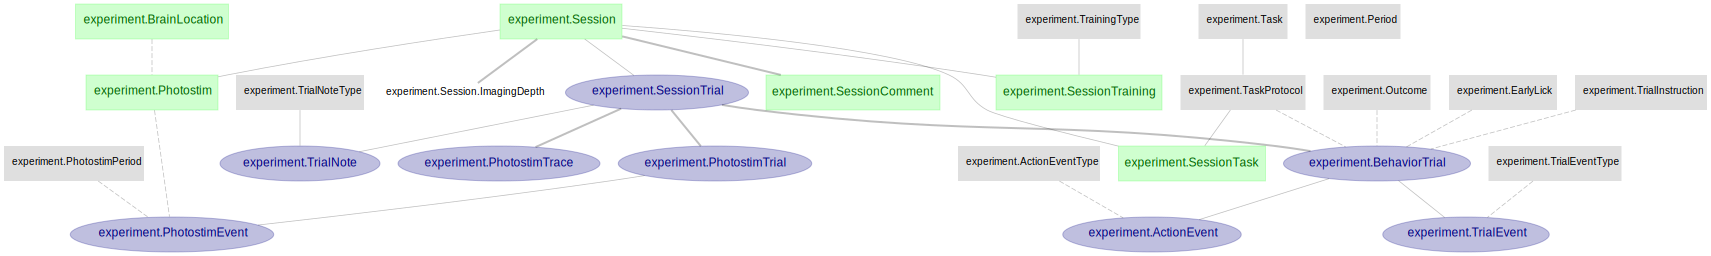

In [6]:
dj.Diagram(experiment)

### Session information

Session information is saved in the table `experiment.Session`:

In [7]:
experiment.Session.describe();

-> lab.Subject
session              : smallint                     # session number
---
session_date         : date                         
fov=1                : tinyint                      # field of view number
-> lab.Person
-> [nullable] lab.Rig



The `experiment.Session` table depends on `lab.Subject`, and inherits the primary key of the subject, `subject_id`. In addition to that, a session performed on a subject is further identified by the session number `session`. The combination of `subject_id` and `session` number uniquely identified each and every session inside `experiment.Session` table.

As an example, here are the sessions performed on subject 216219.

In [8]:
experiment.Session & 'subject_id=216219'

subject_id institution 6 digit animal ID,session session number,session_date,fov field of view number,username,rig
216219,1,2013-08-19,1,Tsai-Wen Chen,None
216219,2,2013-08-16,1,Tsai-Wen Chen,None
216219,3,2013-08-21,1,Tsai-Wen Chen,None
216219,4,2013-08-19,1,Tsai-Wen Chen,None
216219,5,2013-08-15,1,Tsai-Wen Chen,None
216219,6,2013-08-16,1,Tsai-Wen Chen,None
216219,7,2013-08-19,1,Tsai-Wen Chen,None
216219,8,2013-08-21,1,Tsai-Wen Chen,None
216219,9,2013-08-20,1,Tsai-Wen Chen,None
216219,10,2013-08-21,1,Tsai-Wen Chen,None


### Trial information

The general trial information is saved in the table `experiment.SessionTrial`:

In [9]:
experiment.SessionTrial.describe();

-> experiment.Session
trial                : smallint                     # trial number
---
trial_uid=null       : int                          # unique across sessions/animals
start_time           : decimal(8,4)                 # (s) relative to session beginning
stop_time=null       : decimal(8,4)                 # (s) relative to session beginning



The behavioral information is further specified in the the table `experiment.BehavioralTrial`

In [10]:
experiment.BehaviorTrial.describe();

-> experiment.SessionTrial
---
-> experiment.TaskProtocol
-> experiment.TrialInstruction
-> experiment.EarlyLick
-> experiment.Outcome



This table stores information about different aspects of a trial, including:  

1. `TaskProtocol`: in this paper, all trials are from a task of high tone vs. low tone of auto_delay  
  
2. `TrialInstruction`: instructions given to the subject, "left", "right" or "non-performing"
  
3. `Outcome`: subject response of this trial 

    a. "hit": correct when instructed "left" or "right"  
    b. "miss": incorrect when instructed "left" or "right"  
    c. "ignore": did not respond when instructed "left" or "right"  
    d. "non-performing": the animal follow the instruction "non-performing"
      
4. `EarlyLick`:   
    a. "early":  early lick during sample and/or delay  
    b. "early, presample only": early lick in the presample period, after the onset of the scheduled wave but before the sample period  
    c. "no early"

Another important aspect of the trials is the time marks for the trial events ("delay", "go" and "sample"), saved in the table `experiment.TrialEvent`:

In [11]:
experiment.TrialEvent.describe();

-> experiment.BehaviorTrial
trial_event_id       : smallint                     
---
-> experiment.TrialEventType
trial_event_time     : decimal(8,4)                 # (s) from trial start, not session start
duration=null        : decimal(8,4)                 # (s)



In [12]:
experiment.TrialEvent()

subject_id institution 6 digit animal ID,session session number,trial trial number,trial_event_id,trial_event_type,"trial_event_time (s) from trial start, not session start",duration (s)
216219,1,1,1,sample,0.5830,None
216219,1,1,2,delay,1.7830,None
216219,1,1,3,go,3.1830,None
216219,1,2,4,sample,0.5832,None
216219,1,2,5,delay,1.7832,None
216219,1,2,6,go,3.1832,None
216219,1,3,7,sample,1.8140,None
216219,1,3,8,delay,3.0140,None
216219,1,3,9,go,4.4140,None
216219,1,4,10,sample,0.5828,None


## Diagram of schema `imaging`

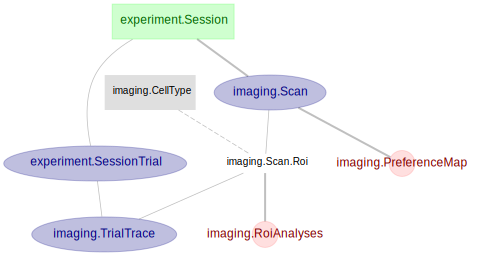

In [13]:
dj.Diagram(imaging) - 1

### ROI and Trace information

ROI segmentation and trace information are stored in `imaging.Scan.Roi`:

In [14]:
imaging.Scan.Roi.describe();

-> imaging.Scan
roi_idx              : int                          
---
-> imaging.CellType
roi_trace            : longblob                     # average fluorescence of roi obj-timeSeriesArrayHash-value(1, 1)-valueMatrix
neuropil_trace       : longblob                     # average fluorescence of neuopil surrounding each ROI, obj-timeSeriesArrayHash-value(1, 1)-valueMatrix
roi_pixel_list       : longblob                     # pixel list of this roi
neuropil_pixel_list  : longblob                     # pixel list of the neuropil surrounding the roi
inc                  : tinyint                      # whether included (criteria - cells > 1.05 times brighter than neuropil)



To facilitate analyses, we also cut the traces into different trials and save the information in the table `imaging.TrialTrace`:

In [15]:
imaging.TrialTrace.describe();

-> imaging.Scan.Roi
-> experiment.SessionTrial
---
original_time        : longblob                     # original time cut for this trial
aligned_time         : longblob                     # 0 is go cue time
aligned_trace        : longblob                     # aligned trace relative to the go cue time
dff                  : longblob                     # dff, normalized with f[0:6]



Computed results of responsiveness and selectivity are stored in the table `imagign.RoiAnalyses`:

In [16]:
imaging.RoiAnalyses.describe();

-> imaging.Scan.Roi
---
dff_m_l              : longblob                     # median dff across trials, for correct left
dff_m_r              : longblob                     # median dff across trials, for correct right
dff_int_l            : float                        # integral dff over task period for left trials
dff_int_r            : float                        # integral dff over task period for right trials
dff_diff             : float                        # dff_int_r - dff_int_l
p_selective          : float                        # p value for trial type selectivity
is_selective         : tinyint                      # whether is trial type selective p < 0.05
selectivity          : enum('Contra','Ipsi','Non selective') # contra or ipsi
p_responsive_l       : float                        # p value for task relevance in left trials
p_responsive_r       : float                        # p value for task relevance in right trials
is_responsive        : tinyint                   

# Figure Replication  

Now let's replicate the figures in Figure 4 by fetching data from the data pipeline.

We start by defining a few helper functions:

In [17]:
def compute_mean_sem(traces):
    """
    Function that computes the mean and the standard errors.
    
    Parameters: 
    traces (2D array): traces of relevant trials

    Returns: 
    mean and standard errors of traces across trials
    """
    
    return np.mean(traces, axis=0), np.std(traces, axis=0)/np.sqrt(len(traces))


def get_event_time(cell):
    """
    Function that gets the event time relative to the go cue time.
    
    Parameters: 
    cell (dict or DataJoint query object):

    Returns: 
    list of mean event time relative to the go cue time.
    """
    
    events = experiment.TrialEvent & (imaging.TrialTrace & cell)
    sample = np.mean((events & 'trial_event_type = "sample"').fetch('trial_event_time'))
    delay = np.mean((events & 'trial_event_type = "delay"').fetch('trial_event_time'))
    go = np.mean((events & 'trial_event_type = "go"').fetch('trial_event_time'))
    # aligned time markers
    sample = float(sample - go)
    delay = float(delay - go)
    return [sample, delay, 0]


def get_event_idx(event_times, time):
    """
    Function that gets the index of the frame for the event time points
    
    Parameters:
    event_times (float or array-like): time point(s) to be found
    time (array-like): time vector with the same length as the trial trace
    
    Returns:
    list of index of the event time points
    """
    
    if len(event_times) == 1:
        return np.abs(time - event_times).argmin()
    else:
        return [np.abs(time - e).argmin() for e in event_times]

## Figure 4 c and d: example imaging plane

This is the primary key of the example scan:

In [18]:
example_scan = {
    'subject_id': 221541,
    'session': 8
}

In [19]:
image_gcamp, image_ctb, image_beads = (imaging.Scan & example_scan).fetch1('image_gcamp', 'image_ctb', 'image_beads')

<IPython.core.display.Javascript object>


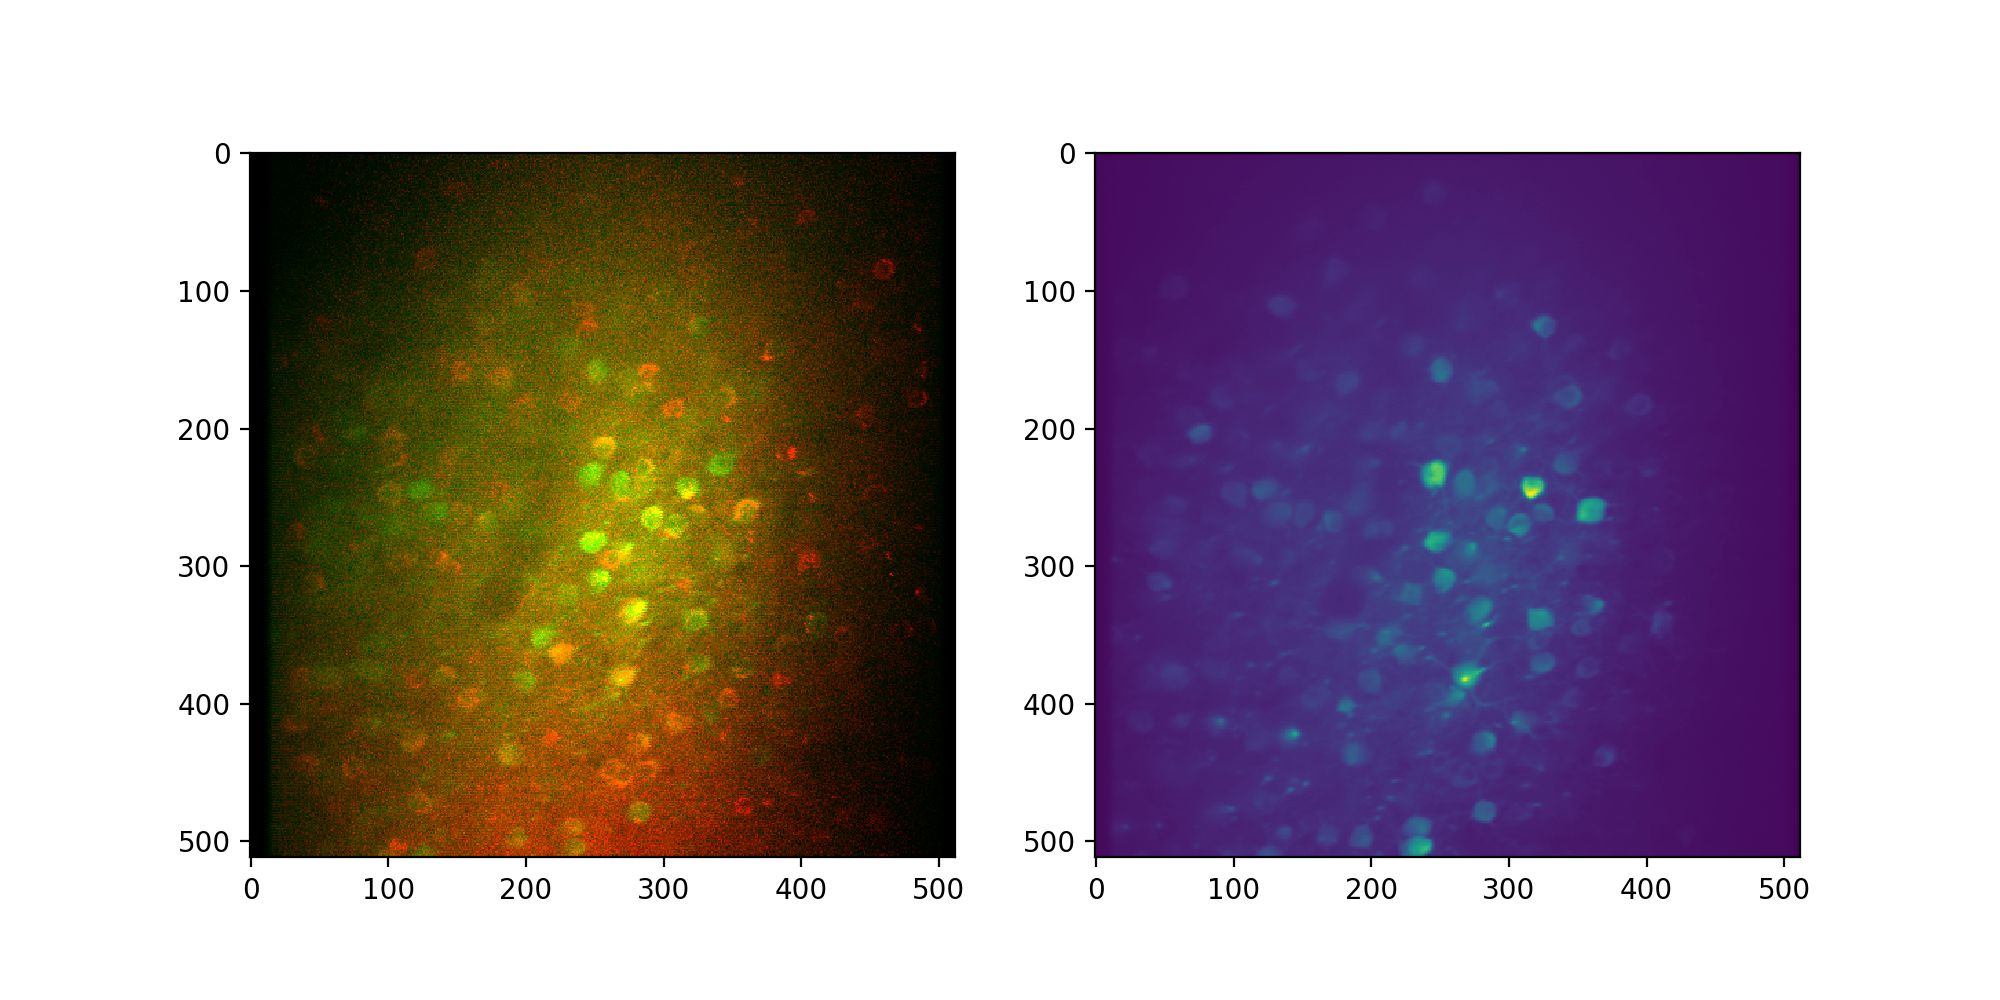

In [20]:
f_cd, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(image_ctb)
axs[1].imshow(image_gcamp)

Left panel is the imaging for ctb and GCaMP6s. Right panel is the GCaMP6s signal

## Figure 4e: calcium activity of example cells during the task period

Here are the primary keys of the example cells:

In [21]:
example_cells = [
    {'subject_id': 216219, 'session': 5, 'roi_idx': 22}, # contra preferring, response starting from the sample period
    {'subject_id': 216219, 'session': 5, 'roi_idx': 49}, # contra preferring, response starting from the delay period
    {'subject_id': 221541, 'session': 13, 'roi_idx': 44}, # contra preferring, response starting from the response period
    {'subject_id': 216219, 'session': 14, 'roi_idx': 9}, # ipsi preferring, response starting from the sample period
    {'subject_id': 216219, 'session': 5, 'roi_idx': 35}, # ipsi preferring, response starting from the delay period
    {'subject_id': 216219, 'session': 6, 'roi_idx': 47}, # ipsi preferring, response starting from the response period
]

<IPython.core.display.Javascript object>


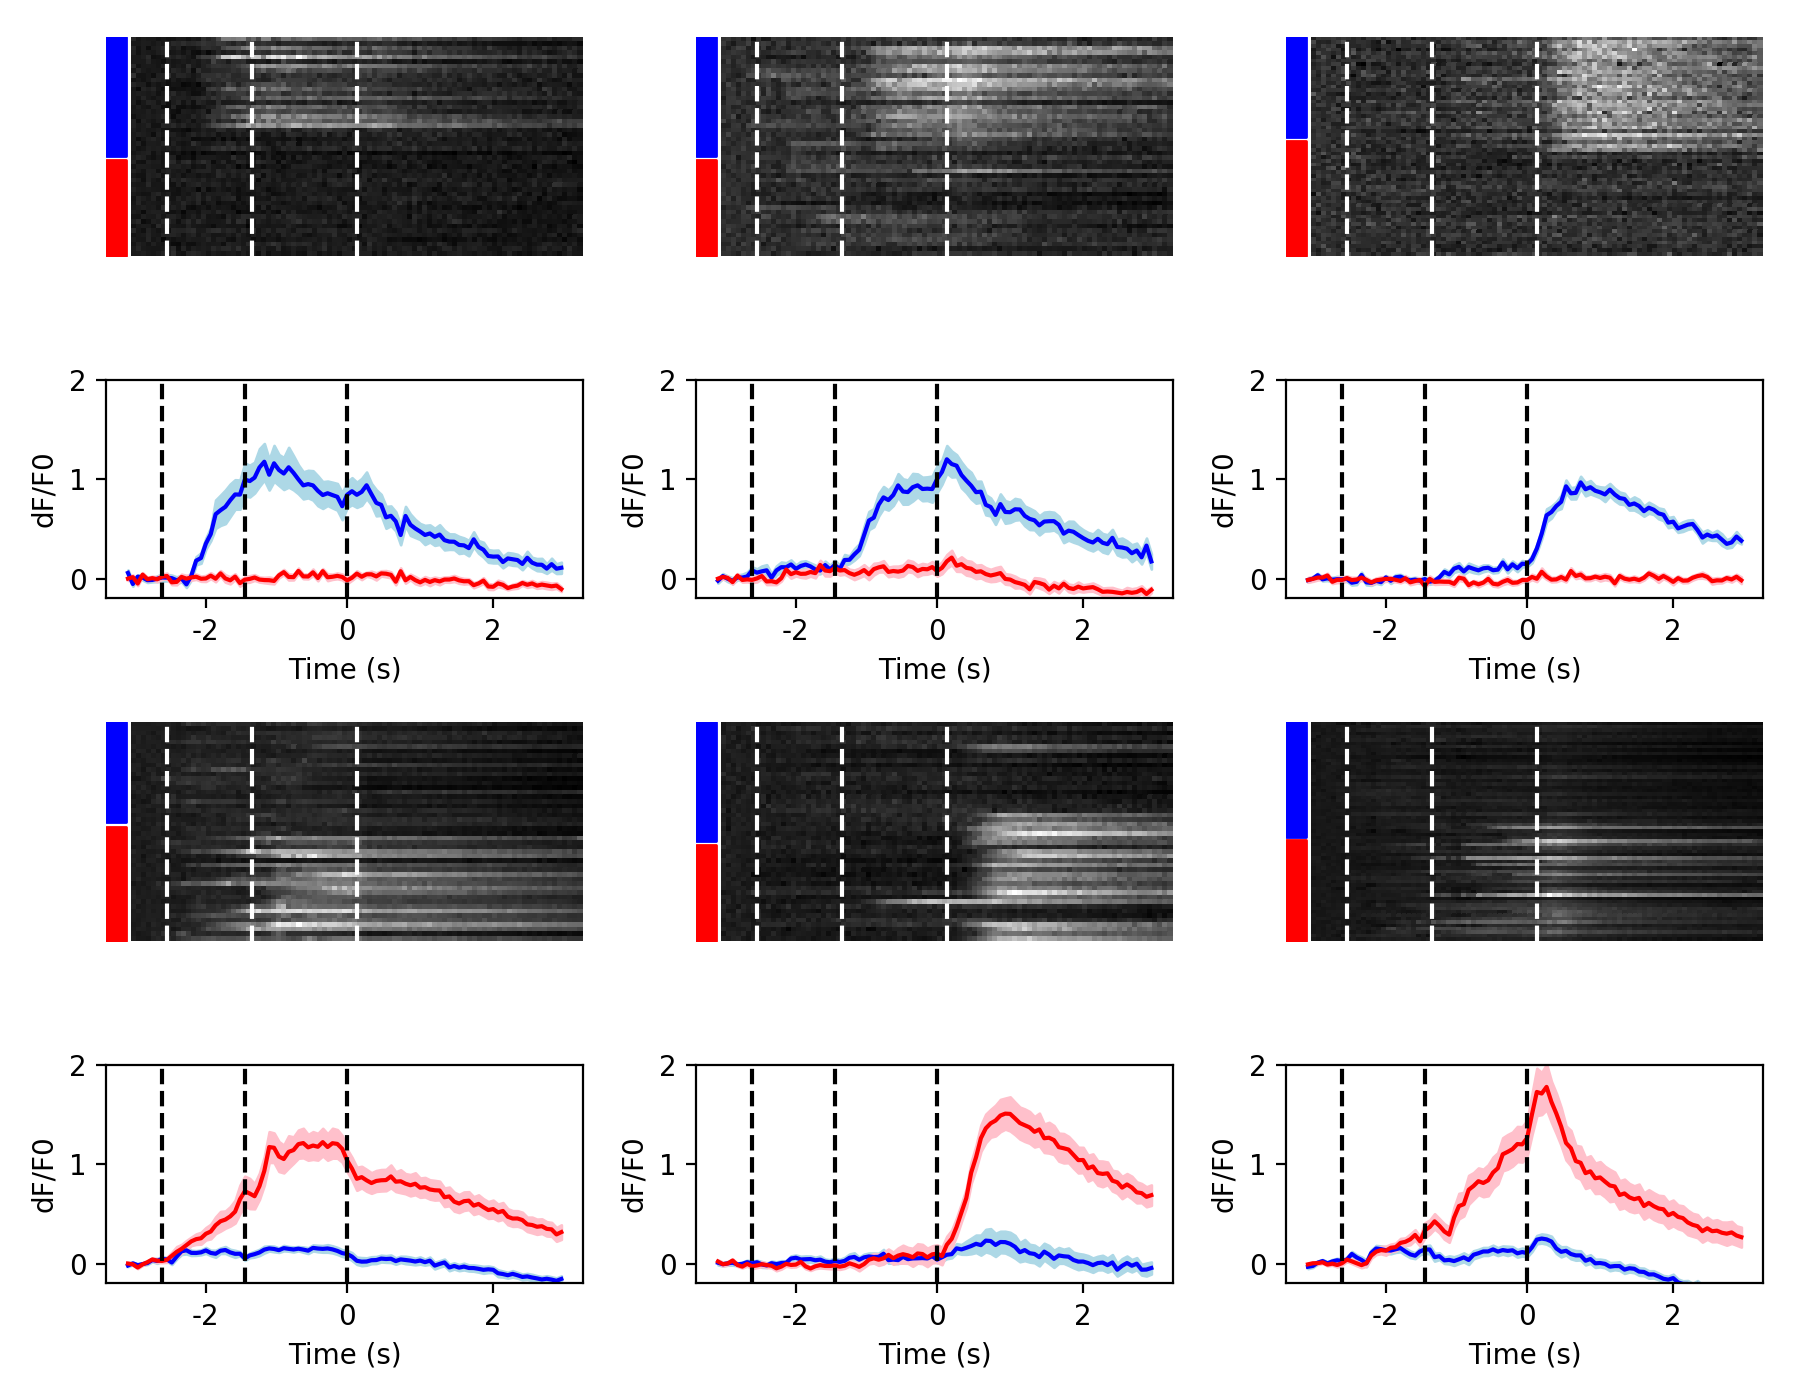

In [22]:
f, axes = plt.subplots(4, 3, figsize=(9, 7))
x2 = -5

axes = axes.flatten()
idx = [[0, 3],
       [1, 4],
       [2, 5],
       [6, 9],
       [7, 10],
       [8, 11]]
axes = [axes[i] for i in idx]

for cell, axs in zip(example_cells, axes):

    # get trace of left hit trials by fetching from the table 
    time_left, traces_left = ((imaging.TrialTrace & cell) &
                   (experiment.BehaviorTrial & 'trial_instruction="left"' & 'outcome="hit"')).fetch(
        'aligned_time', 'dff')
    traces_right = ((imaging.TrialTrace & cell) &
                   (experiment.BehaviorTrial & 'trial_instruction="right"' & 'outcome="hit"')).fetch(
        'dff')
    traces_left = [trace for trace in traces_left]
    traces_right = [trace for trace in traces_right]
    time = time_left[0]
    
    # plot heat map
    sns.heatmap(traces_right+traces_left, cmap='gray', cbar=None, ax=axs[0])
    axs[0].fill_betweenx([0, len(traces_left)-1], -1, x2, color='blue')
    axs[0].fill_betweenx([len(traces_left), len(traces_left) + len(traces_right)], -1, x2, color='red')

    # mark event time points
    event_times = get_event_time(cell)
    for idx in get_event_idx(event_times, time):
        axs[0].axvline(x=idx, linestyle='--', color='white')
        
    axs[0].set_xticks([])
    axs[0].set_yticks([])
    axs[0].set_xlim((x2, axs[0].get_xlim()[1]))
    
    # mean df/f
    mean_left, sem_left = compute_mean_sem(traces_left)
    mean_right, sem_right = compute_mean_sem(traces_right)
    x = range(0, len(mean_right))
    axs[1].fill_between(x, mean_right-sem_right, mean_right+sem_right, color='lightblue')
    axs[1].plot(x, mean_right, color='blue')
    axs[1].fill_between(x, mean_left-sem_left, mean_left+sem_left, color='pink')
    axs[1].plot(x, mean_left, color='red')
    axs[1].set_ylabel('dF/F0')
    axs[1].set_xlabel('Time (s)')
    xticks = get_event_idx([-2, 0, 2], time)
    axs[1].set_xticks(ticks=xticks)
    labels=['-2', '0', '2']
    axs[1].set_xticklabels(labels)
    
    # mark event time points
    for idx in get_event_idx(event_times, time):
        axs[1].axvline(x=idx, linestyle='--', color='black')
       
    axs[1].set_ylim([-0.2, 2])

f.tight_layout()
f.savefig('/images/example_cells.png', dpi=300)

Red marks the Contra trials, while blue marks the Ipsi trials. The three vertical dashed lines mark the sample, delay, and the go cue time.

## Figure 4f: Preference map

We pre-computed the preference map in the table `imaging.PreferenceMap`, where contra-preferred cells are marked blue, ipsi-preferred cells are marked red, and non-selective cells are marked gray.

In [23]:
imaging.PreferenceMap()

subject_id institution 6 digit animal ID,session session number,preference_map 512 x 512 x 3 matrix of RGB
216219,1,=BLOB=
216219,2,=BLOB=
216219,3,=BLOB=
216219,4,=BLOB=
216219,5,=BLOB=
216219,6,=BLOB=
216219,7,=BLOB=
216219,8,=BLOB=
216219,9,=BLOB=
216219,10,=BLOB=


In [24]:
# primary key of the example map
example_map = {
    'subject_id': 226244,
    'session': 8
}

<IPython.core.display.Javascript object>


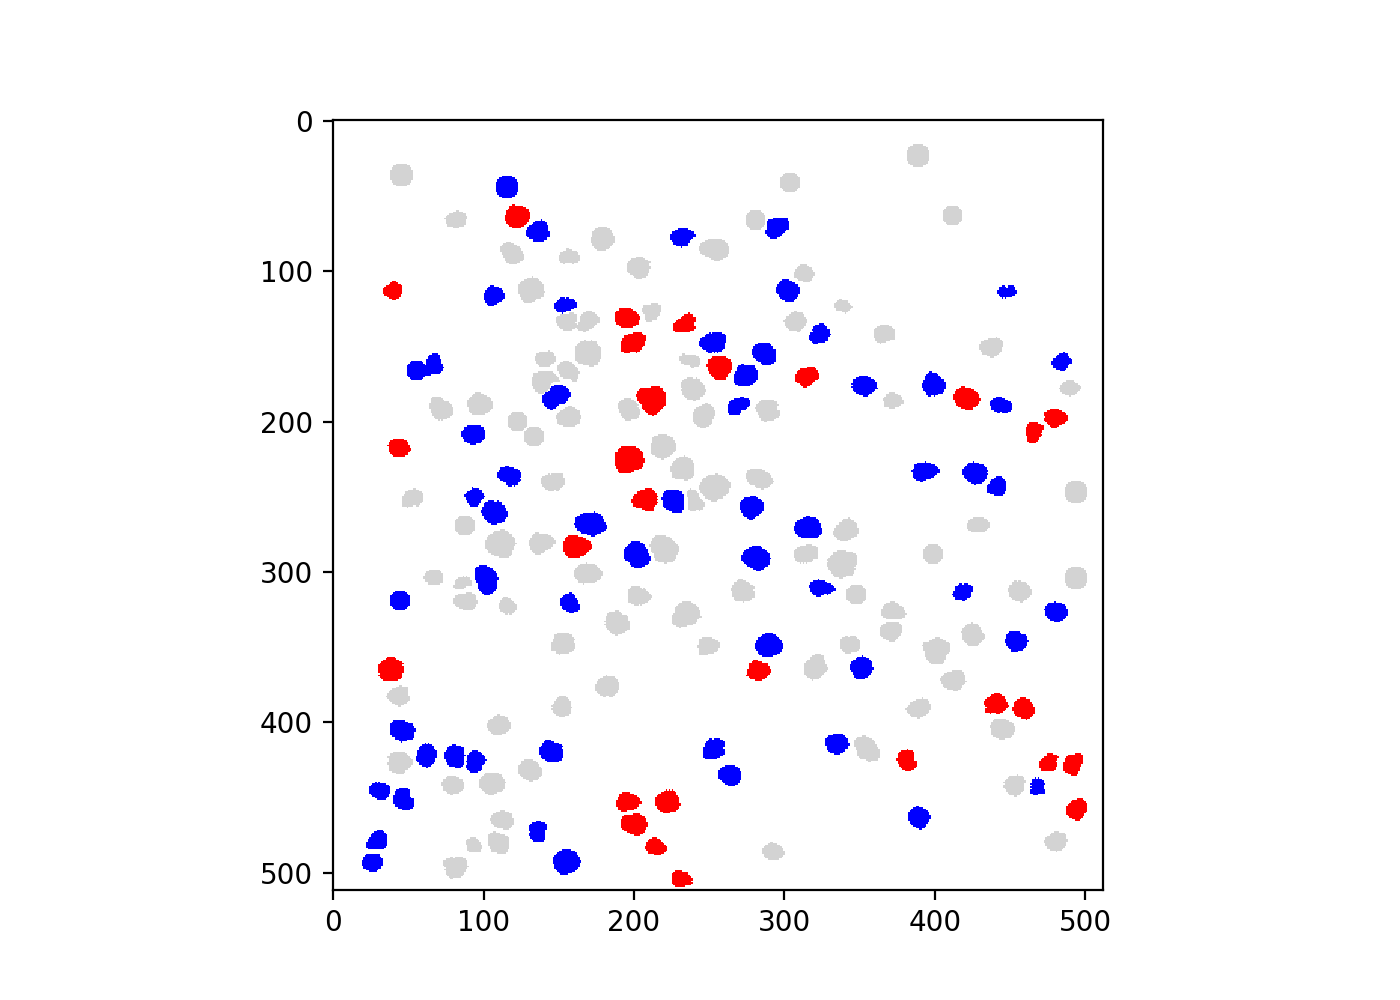

In [32]:
im = (imaging.PreferenceMap & example_map).fetch1('preference_map')
im = im.transpose(1, 0, 2)
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.imshow(im)

## Figure 4g: Population activity of PT cells and IT cells

In [27]:
def plot_summary(cell_type, save=False):
    """
    Function that creates the population activity
    
    Parameters:
    cell_type: 'PT' or 'IT'
    """
    
    # query for L5 cells, deeper than 450 um
    L5_key = (experiment.Session.ImagingDepth & 'imaging_depth>450')
    
    # query the contra-preferred cells
    contra_cells = (imaging.RoiAnalyses & 'is_responsive=1' & 'selectivity="Contra"') & \
                    (imaging.Scan.Roi & f'cell_type="{cell_type}"' & 'inc=1') & L5_key

    # query the ipsi-preferred cells
    ipsi_cells = (imaging.RoiAnalyses & 'is_responsive=1' & 'selectivity="Ipsi"') & \
                  (imaging.Scan.Roi & f'cell_type="{cell_type}"' & 'inc=1') & L5_key
    
    # average df/f of contra trials, sorted by the response time of the half peak.
    contra_avg_l, contra_avg_r = contra_cells.fetch('dff_m_l', 'dff_m_r', order_by='frame_rise_half')
    
    # average df/f of contra trials, sorted by the response time of the half peak.
    ipsi_avg_l, ipsi_avg_r = ipsi_cells.fetch('dff_m_l', 'dff_m_r', order_by='frame_rise_half')
    
    
    contra_avg_l = [f for f in contra_avg_l]
    contra_avg_r = [f for f in contra_avg_r]
    ipsi_avg_l = [f for f in ipsi_avg_l]
    ipsi_avg_r = [f for f in ipsi_avg_r]
    
    
    # Set up the figure panels
    grid_kws = {"width_ratios": (.45, .45, .02)}
    fig, axes = plt.subplots(1, 3, gridspec_kw=grid_kws, figsize=[7, 5])
    
    # plot the trace activity as heat map
    sns.heatmap(contra_avg_r+ipsi_avg_r, vmax=0.8, vmin=-0.8, ax=axes[0], cbar=None)
    sns.heatmap(contra_avg_l+ipsi_avg_l, vmax=0.8, vmin=-0.8, ax=axes[1], cbar_ax=axes[2], cbar_kws={'label': 'df/f'})
    
    # mark the neuro reference, blue for contra-preferred and red for ipsi-preferred
    axes[0].fill_betweenx([0, len(contra_avg_r)-1], -1, x2, color='blue')
    axes[0].fill_betweenx([len(contra_avg_r), len(contra_avg_r) + len(contra_avg_l)], -1, x2, color='red')
    axes[0].set_xlim((x2, axes[0].get_xlim()[1]))
    axes[1].set_xlim((x2, axes[0].get_xlim()[1]))
    axes[0].set_title('Contra trials', y=0.95, fontsize=10)
    axes[1].set_title('Ipsi trials', y=0.95, fontsize=10)
    fig.suptitle(f'{cell_type} neurons', y=1, x=0.45, fontsize=12)
    
    x_ticks = get_event_idx([-2, 0, 2], time)
    
    for ax in axes[:-1]:
        ax.set_xticks(x_ticks)
        ax.set_xticklabels(['-2', '0', '2'], rotation='horizontal')
        ax.set_xlabel('Time (s)')
        ax.set_yticks([])

    # mark event time points
    for idx in get_event_idx(event_times, time):
        axes[0].axvline(x=idx, linestyle='--', color='black')
        axes[1].axvline(x=idx, linestyle='--', color='black')

    axes[0].set_ylabel('Neuron number')
    
    fig.tight_layout()
    if save:
        fig.savefig(f'/images/{cell_type} summary.png', dpi=300)

<IPython.core.display.Javascript object>


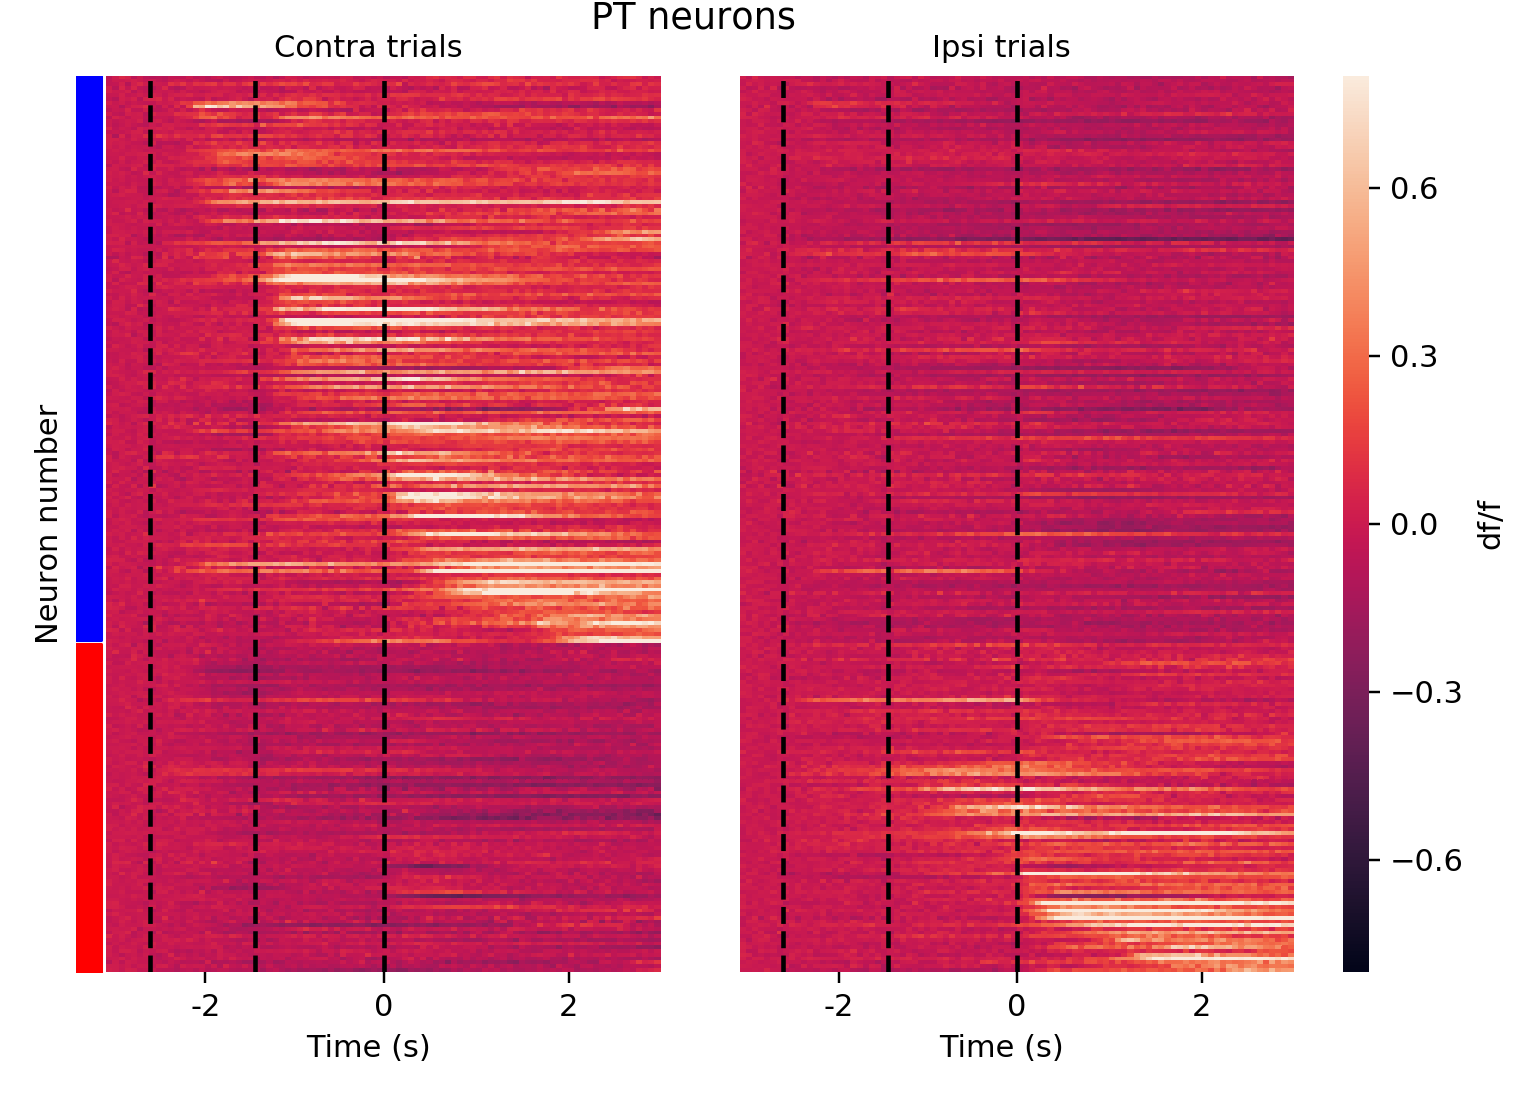

In [28]:
plot_summary('PT')

<IPython.core.display.Javascript object>


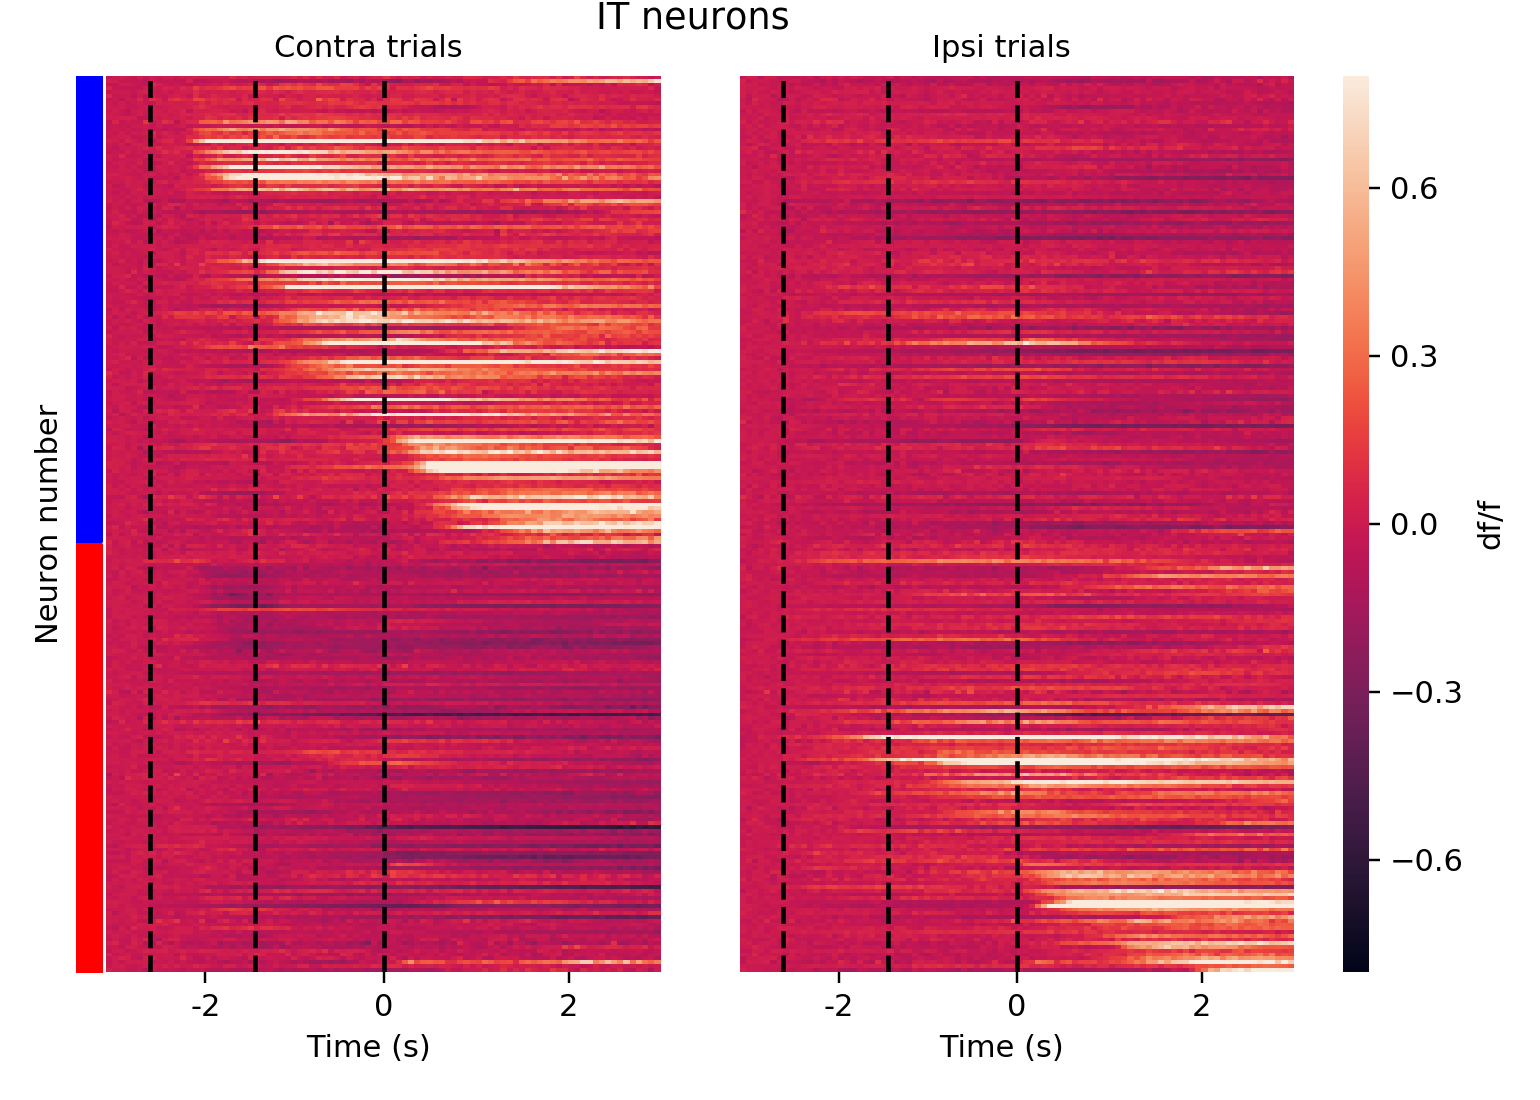

In [59]:
plot_summary('IT')

## Figure 4h: Fraction of contra-preferred neurons for both PT and IT population

In [29]:
# L5 cell query
L5_key = (experiment.Session.ImagingDepth & 'imaging_depth>450')

# PT all selective cells
PT_selective_cells = (imaging.RoiAnalyses & 'is_responsive=1' & 'is_selective=1') & \
                     (imaging.Scan.Roi & 'cell_type="PT"' & 'inc=1') & L5_key
# PT contra-preferred cells
PT_contra_cells = (imaging.RoiAnalyses & 'is_responsive=1' & 'selectivity="Contra"') & \
                  (imaging.Scan.Roi & 'cell_type="PT"' & 'inc=1') & L5_key

n_PT_selective_cells = len(PT_selective_cells)
n_PT_contra_cells = len(PT_contra_cells)

In [30]:
# IT all selective cells
IT_selective_cells = (imaging.RoiAnalyses & 'is_responsive=1' & 'is_selective=1') & \
                     (imaging.Scan.Roi & 'cell_type="IT"' & 'inc=1') & L5_key
# IT contra-preferred cells
IT_contra_cells = (imaging.RoiAnalyses & 'is_responsive=1' & 'selectivity="Contra"') & \
                  (imaging.Scan.Roi & 'cell_type="IT"' & 'inc=1') & L5_key

n_IT_selective_cells = len(IT_selective_cells)
n_IT_contra_cells = len(IT_contra_cells)

In [31]:
def compute_boot_strapped_sem(n_total, fraction, n_samples):
    return np.std(np.random.binomial(n_total, fraction, [1, n_total]))/np.sqrt(n_samples)

In [32]:
contra_frac_PT = n_PT_contra_cells/n_PT_selective_cells
contra_frac_IT = n_IT_contra_cells/n_IT_selective_cells

contra_frac_PT_sem = compute_boot_strapped_sem(n_PT_selective_cells, contra_frac_PT, 10000)
contra_frac_IT_sem = compute_boot_strapped_sem(n_IT_selective_cells, contra_frac_IT, 10000)

<IPython.core.display.Javascript object>


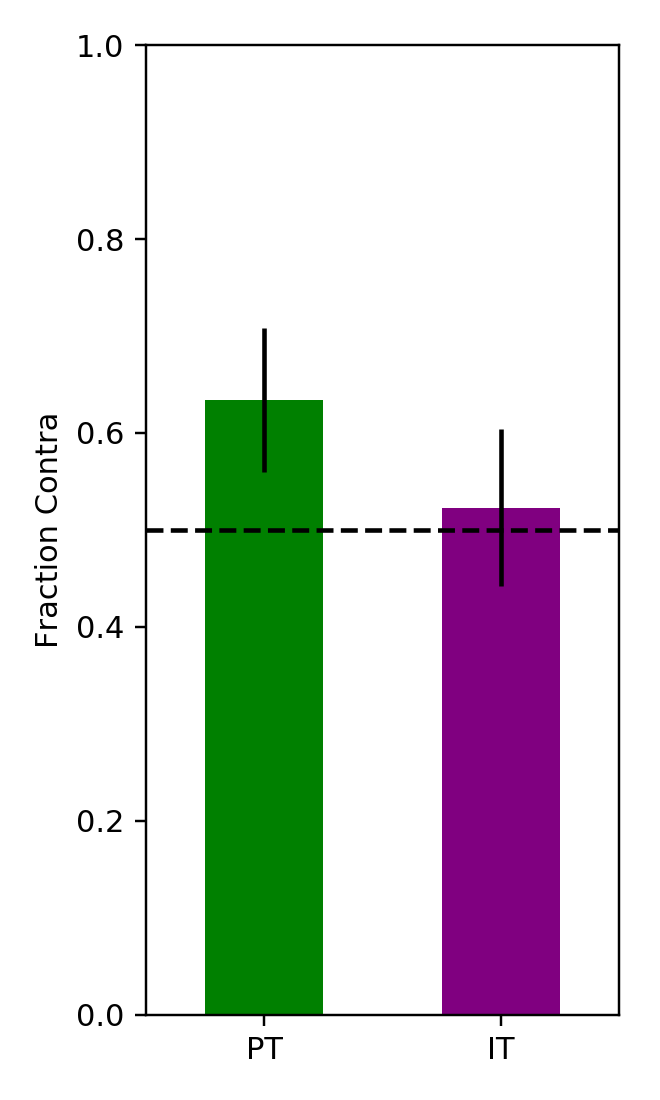

In [33]:
fig, ax = plt.subplots(1, 1, figsize=[3, 5])
ax.bar(['PT', 'IT'], [contra_frac_PT, contra_frac_IT], 
       yerr=[contra_frac_PT_sem, contra_frac_IT_sem], width=0.5,
       color=['green', 'purple'])

x_lim = [-0.5, 1.5]
ax.hlines(y=0.5, xmin=x_lim[0], xmax=x_lim[1], linestyles='--')
ax.set_ylim([0, 1])
ax.set_xlim([-0.5, 1.5])
ax.set_ylabel('Fraction Contra')
fig.tight_layout()

In [34]:
# Chi-square test
avg_frac = (n_PT_contra_cells + n_IT_contra_cells)/(n_PT_selective_cells + n_IT_selective_cells)
stats.chisquare(f_obs=[n_PT_contra_cells, n_IT_contra_cells], 
                f_exp=np.array([n_PT_selective_cells, n_IT_selective_cells])*avg_frac)

Power_divergenceResult(statistic=2.552399443996081, pvalue=0.1101268910576786)